In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import seaborn as sns
import src.bayesian_stats as bst
import xarray as xr
import aesara.tensor as at

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [ ]:
df = pd.read_csv('../kruschke_data/Salary.csv', usecols=[0,3,5], dtype={'Org': 'category', 'Pos': 'category'})
df.head()

In [ ]:
# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

df.info()

In [ ]:
df.groupby('Pos').apply(lambda x: x.head(2))

In [ ]:
y = df.Salary
mu_y = y.mean()
sigma_y = y.std()

x1 = df.Pos
x2 = df.Org

a_shape, a_rate = bst.gamma_shape_rate_from_mode_sd(sigma_y / 2 , 2 * sigma_y)
x1_vals, levels1, n_levels1 = bst.parse_categorical(x1)
x2_vals, levels2, n_levels2 = bst.parse_categorical(x2)

with pm.Model(coords={"rank": levels1, "dept": levels2}) as model:
    
    #a0 = pm.Normal('a0', mu_y, tau=1/(sigma_y*5)**2)
    a0_tilde = pm.Normal('a0_tilde', mu=0, sigma=1)
    a0 = pm.Deterministic('a0', mu_y + sigma_y * 5 * a0_tilde)
        
    sigma_a1 = pm.Gamma('sigma_a1', a_shape, a_rate)
    #a1 = pm.Normal('a1', 0.0, tau=1/sigma_a1**2, shape=n_levels1)
    a1_tilde = pm.Normal('a1_tilde', mu=0, sigma=1, dims="rank")
    a1 = pm.Deterministic('a1', 0.0 + sigma_a1*a1_tilde)
    
    sigma_a2 = pm.Gamma('sigma_a2', a_shape, a_rate)
    #a2 = pm.Normal('a2', 0.0, tau=1/sigma_a2**2, shape=n_levels2)
    a2_tilde = pm.Normal('a2_tilde', mu=0, sigma=1, dims="dept")
    a2 = pm.Deterministic('a2', 0.0 + sigma_a2*a2_tilde)
        
    sigma_a1a2 = pm.Gamma('sigma_a1a2', a_shape, a_rate)
    #a1a2 = pm.Normal('a1a2', 0.0, 1/sigma_a1a2**2, shape=(n_levels1, n_levels2))
    a1a2_tilde = pm.Normal('a1a2_tilde', mu=0, sigma=1, dims=("rank", "dept"))
    a1a2 = pm.Deterministic('a1a2', 0.0 + sigma_a1a2*a1a2_tilde)
        
    mu = a0 + a1[x1_vals] + a2[x2_vals] +a1a2[x1_vals, x2_vals]
    sigma = pm.Uniform('sigma', sigma_y / 100, sigma_y * 10)
    
    likelihood = pm.Normal('likelihood', mu, sigma=sigma, observed=y) 
    
    idata = pm.sample(nuts={'target_accept': 0.95})



In [ ]:
pm.plot_trace(idata, var_names=['a0', 'a1', 'sigma_a1', 'a2', 'sigma_a2', 'a1a2', 'sigma_a1a2', 'sigma']);

In [ ]:
post = az.extract(idata.posterior)
len(post['sample'])
post

In [ ]:
post = post.assign(m=(["rank", "dept", "sample"], np.zeros((n_levels1, n_levels2, len(post['sample'])))))
post = post.assign(b1b2=(["rank", "dept", "sample"], np.zeros((n_levels1, n_levels2, len(post['sample'])))))
post

In [ ]:
# Transforming the trace data to sum-to-zero values. First, calculate
# predicted mean values based on different levels of predictors.
for (j1, j2) in np.ndindex(n_levels1, n_levels2):
        post.m[j1, j2] =  (post['a0'] +
                     post['a1'][j1, :] +
                     post['a2'][j2, :] +
                     post['a1a2'][j1, j2, :])

m = post.m
b1b2 = post.b1b2
b0 = m.mean(dim=["rank", "dept"])
b1 = m.mean(dim="dept") - b0
b2 = m.mean(dim="rank") - b0
        
for (j1, j2) in np.ndindex(n_levels1, n_levels2):
        b1b2[j1,j2] = (m[j1, j2] - (b0 + b1[j1] + b2[j2]))

# Below are the values corresponding to the first column of table 20.2
print(f'b0: {format(np.round(np.mean(b0)))}')
# print('b1: {}'.format(np.round(np.mean(b1, axis=1))))
# print('b2: {}'.format(np.round(np.mean(b2, axis=1))[[20,48,12,7]]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,48]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,48]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[0,12]))
# print('b1b2: {}'.format(np.round(np.mean(b1b2, axis=2))[2,12]))
# print('ySigma: {}'.format(np.round(np.mean(trace1['ySigma']))))

In [ ]:
# Create a dict of contrasts using label-based indexing
contrasts = {"Assoc vs Assis": b1.sel(rank="Assoc") - b1.sel(rank="Assis"),
            "CHEM vs PSY": b2.sel(dept="CHEM") - b2.sel(dept="PSY"),
            "BFIN vs PSY.CHEM.ENG": b2.sel(dept="BFIN") - b2.sel(dept=["PSY", "CHEM", "ENG"]).mean()}
az.plot_posterior(contrasts, kind="hist", point_estimate="mode", ref_val=0);


In [ ]:
# The posteriors for the main contrasts can be calculated directly from the parameters.
# The posterior for the interaction contrast (rightmost plot) however, is calculated as follows.

# Full vs Assis
P = np.zeros(n_levels1, dtype=int)
P[df.Pos.cat.categories == 'Full'] = 1
P[df.Pos.cat.categories == 'Assis'] = -1

# CHEM vs PSY
O = np.zeros(n_levels2, dtype=int)
O[df.Org.cat.categories == 'CHEM'] = 1
O[df.Org.cat.categories == 'PSY'] = -1

# The signs in the above vectors can be flipped, the end result (posterior) will be the same.
# Using the outer product of these two vectors, we get the matrix we need to multiply
# with the trace values of b1b2.
ic_factors = np.outer(P,O)
pd.DataFrame(ic_factors, index=df.Pos.cat.categories, columns=df.Org.cat.categories)

In [ ]:
interactions = {"Full - Assis @ PSY": m.sel(rank="Full", dept="PSY") - m.sel(rank="Assis", dept="PSY"),
                "Full - Assis @ CHEM": m.sel(rank="Full", dept="CHEM") - m.sel(rank="Assis", dept="CHEM"),
               "Full.v.Assis x CHEM.v.PSY": 
                (b1b2.sel(rank="Full", dept="CHEM") - b1b2.sel(rank="Assis", dept="CHEM") - 
                (b1b2.sel(rank="Full", dept="PSY") - b1b2.sel(rank="Assis", dept="PSY")))}
az.plot_posterior(interactions, combine_dims={"sample"});
# interactions

In [ ]:
b1b2

In [ ]:
print(post["a1"].values.shape)
print(m.shape)
test = np.mean(m, axis=1)
post["b0"].values.shape
# test.shape
test = np.mean(m, axis=1) - post["b0"].values

In [ ]:
post

In [ ]:
post["b0"].data[0:10]

## Split-plot ANOVA

In [23]:
df2 = pd.read_csv('../kruschke_data/SplitPlotAgriData.csv')
df2.Field = df2.Field.astype('category')
df2.Till = df2.Till.astype('category')
df2.Fert = df2.Fert.astype('category')
df2.info()

# Between-subjects factor (i.e., group)
x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(df2.Till)

# Within-subjects factor (i.e., target set)
x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(df2.Fert)

# Individual subjects
x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(df2.Field)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Field   99 non-null     category
 1   Till    99 non-null     category
 2   Fert    99 non-null     category
 3   Yield   99 non-null     int64   
dtypes: category(3), int64(1)
memory usage: 2.8 KB


In [4]:
df2.head()

Field    Till     Fert  Yield
0     1  Chisel    Broad    119
1     1  Chisel     Deep    130
2     1  Chisel  Surface    123
3     2  Chisel    Broad    135
4     2  Chisel     Deep    148

/Users/hyosubkim/opt/anaconda3/envs/bayes_toolbox/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


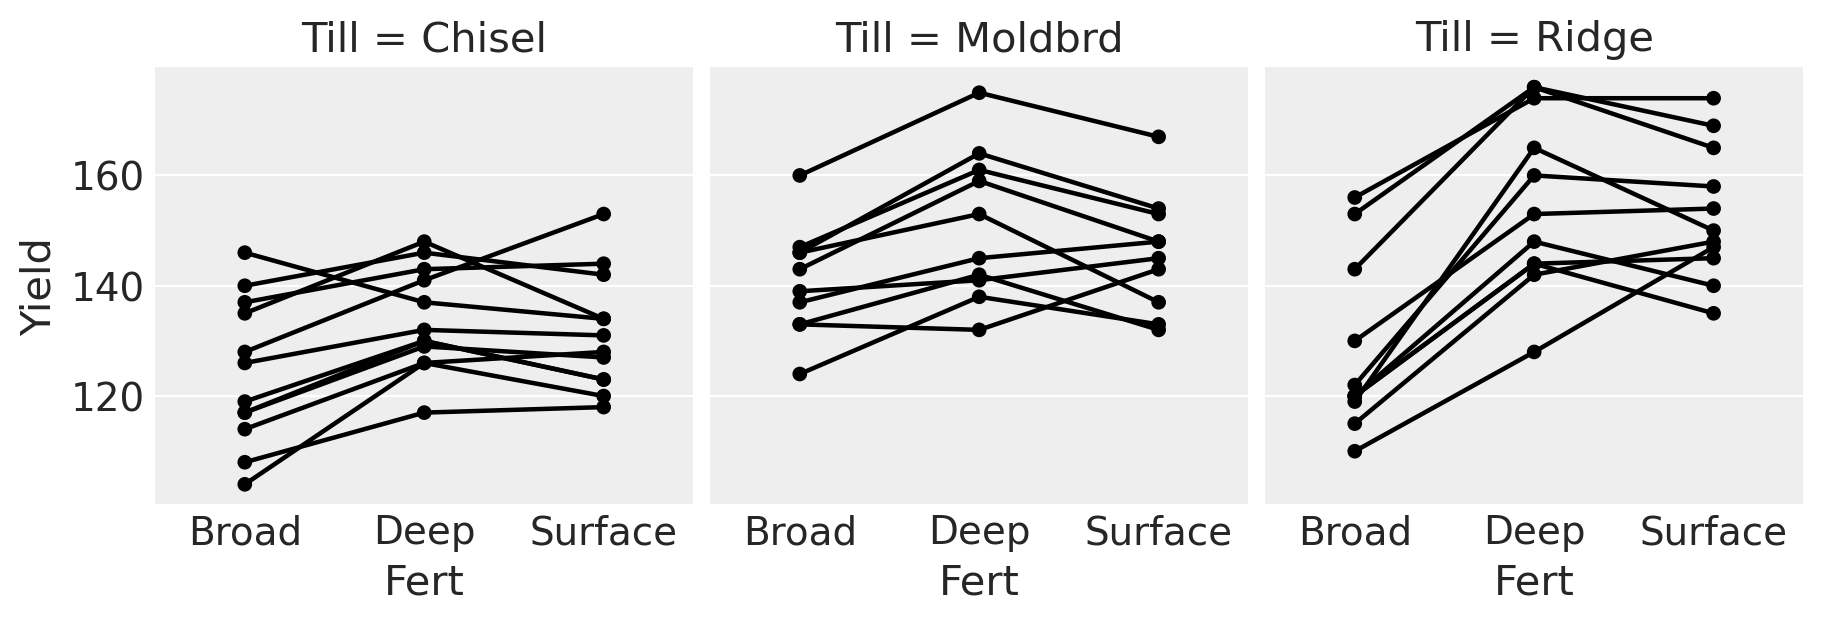

In [5]:
g = sns.FacetGrid(df2, col='Till', hue='Field')
g.map(sns.pointplot, 'Fert', 'Yield', color='k', scale=0.6);

In [6]:
model2, idata2 = bst.mixed_model_anova(df2.Till, df2.Fert, df2.Field, df2.Yield)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, sigma_B, aB, sigma_W, aW, sigma_BxW, aBxW, sigma_S, aS, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 267 seconds.


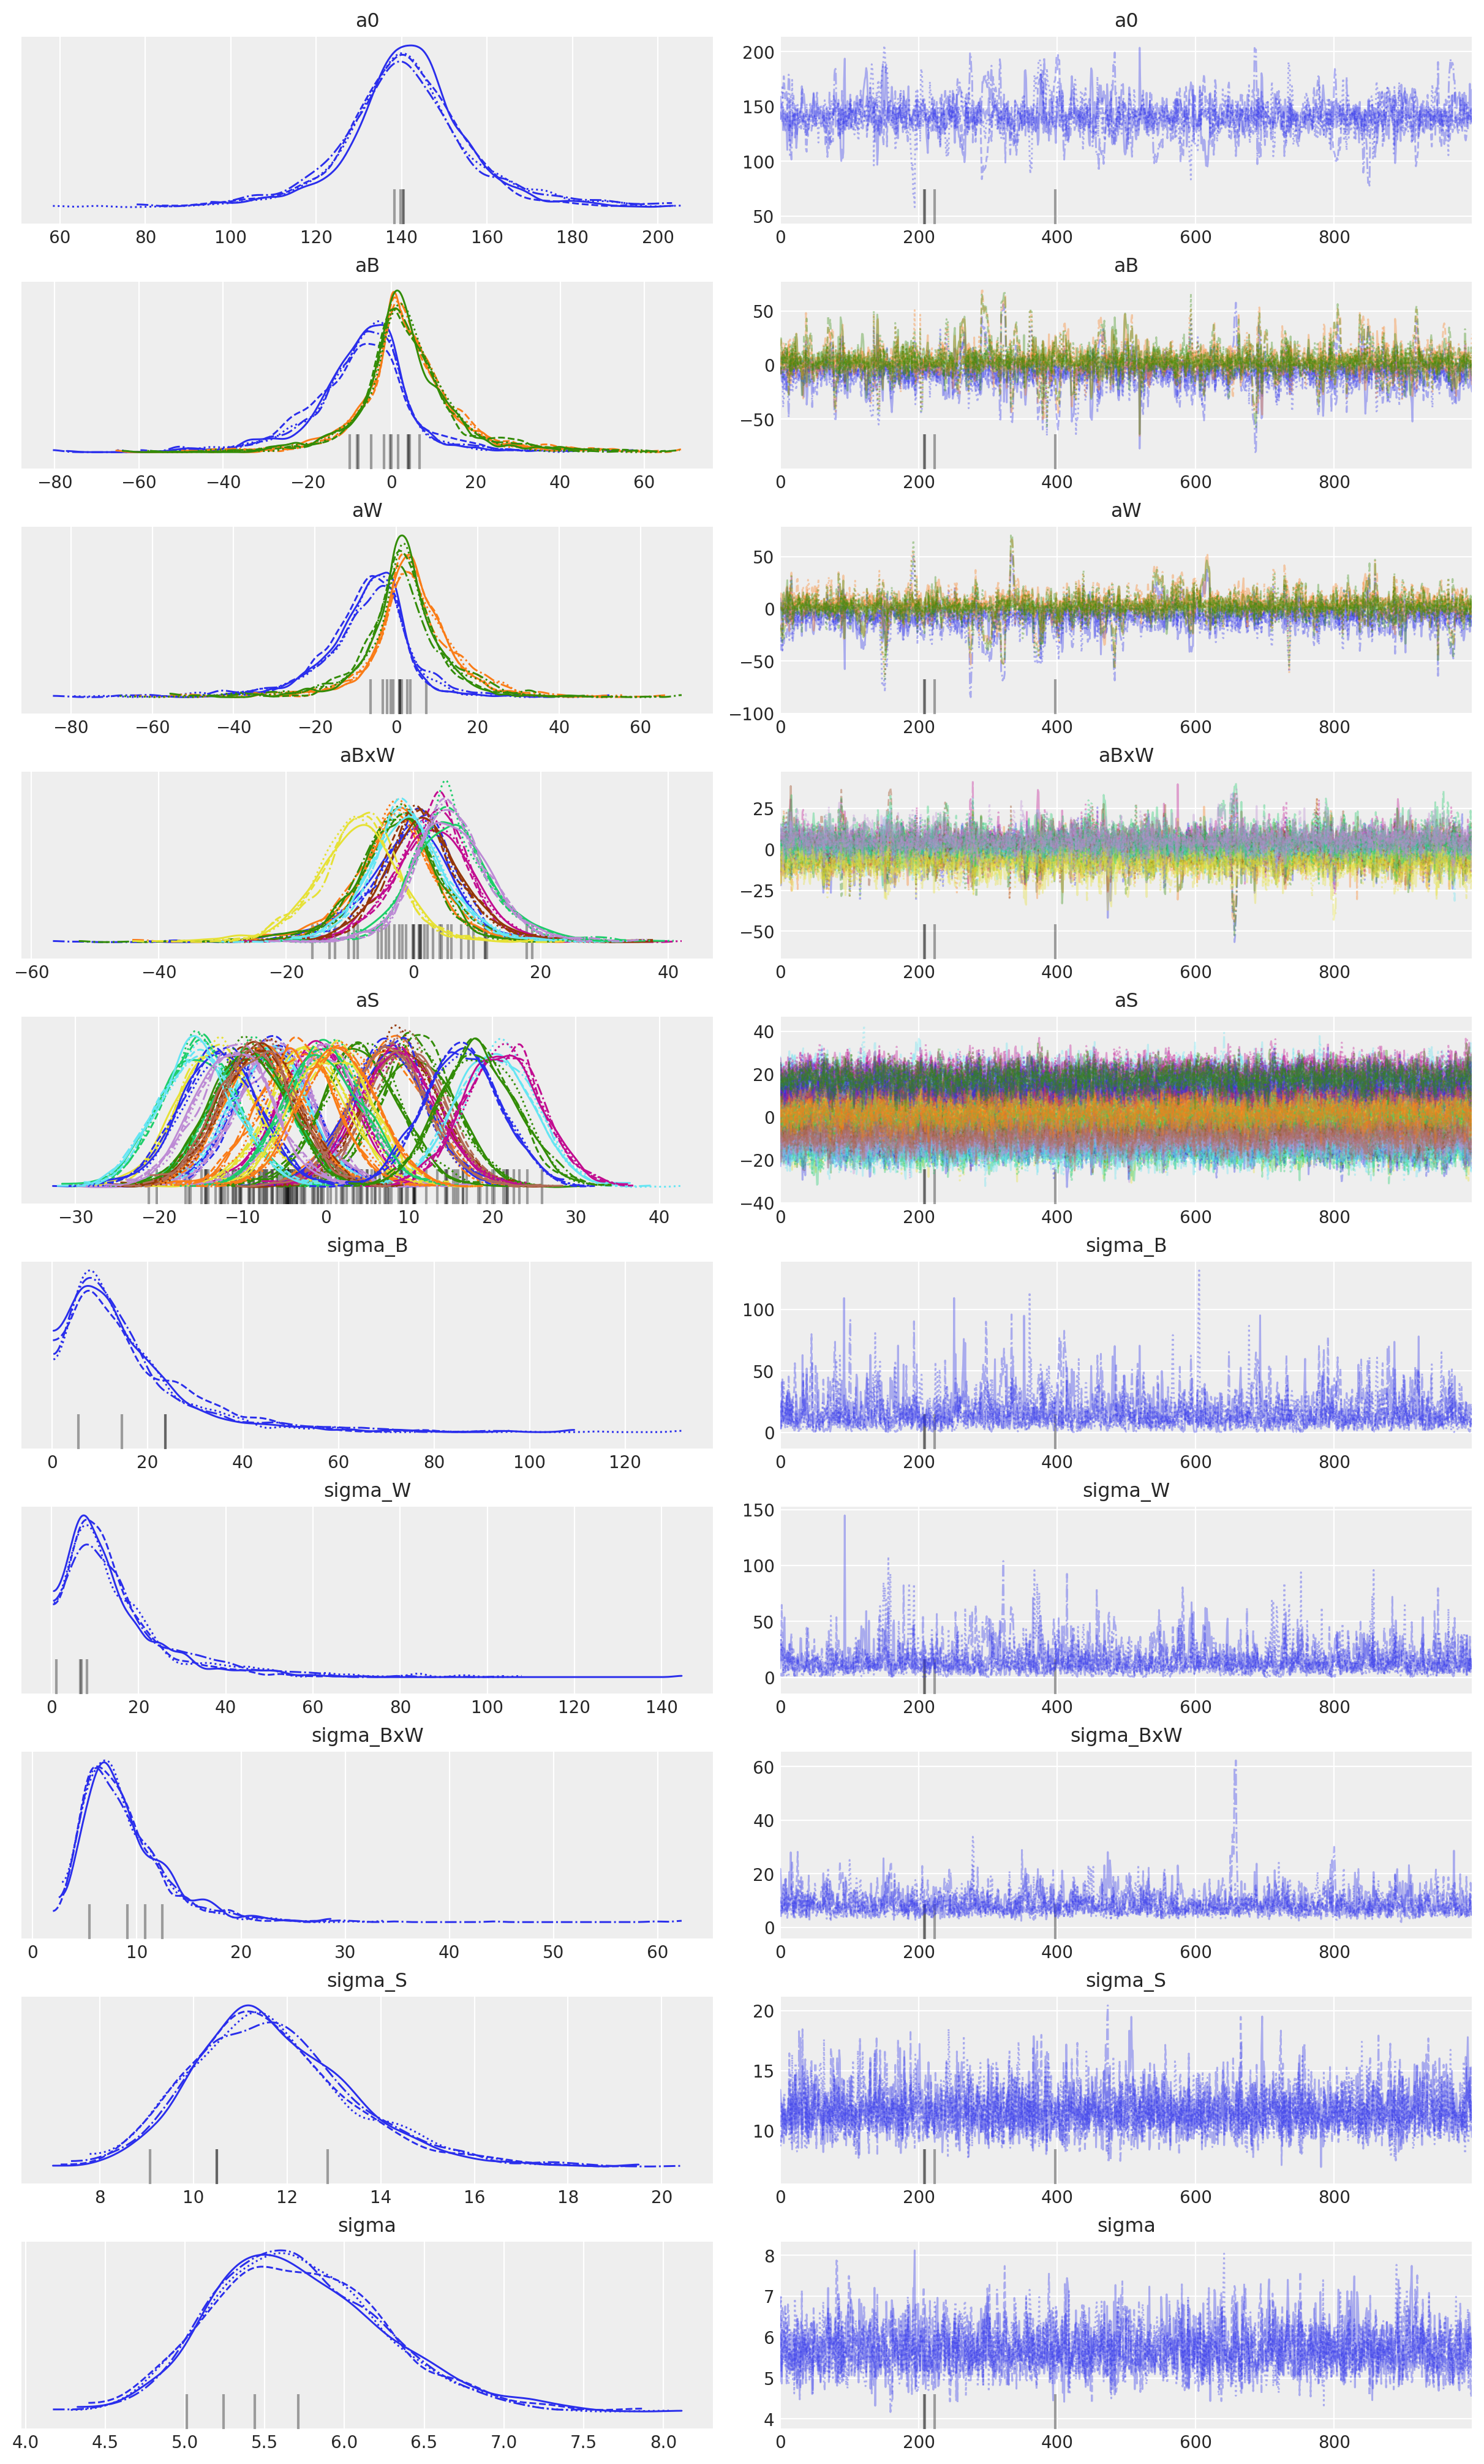

In [7]:
az.plot_trace(idata2);

In [8]:
# Extract posterior estimates for parameters
# Parse all of the categorical vars
# Calculate marginal means
# Convert params to sum-to-zero deflections

In [20]:
def unpack_posterior_vars(posterior):
    
    a0 = posterior["a0"]
    aB = posterior['aB']
    aW = posterior['aW']
    aBxW = posterior['aBxW']
    aS = posterior['aS']
    sigma = posterior['sigma']
    
    return a0, aB, aW, aBxW, aS, sigma
    

def calc_predicted_mus(a0, aB, aW, aBxW, aS, posterior, between_subj_var, within_subj_var, subj_id):
    
    # Between-subjects factor (i.e., group)
    x_between, levels_x_between, num_levels_x_between = bst.parse_categorical(between_subj_var)

    # Within-subjects factor (i.e., target set)
    x_within, levels_x_within, num_levels_x_within = bst.parse_categorical(within_subj_var)

    # Individual subjects
    x_subj, levels_x_subj, num_levels_x_subj = bst.parse_categorical(subj_id)
    
    # Initialize the array with zeros
    posterior = posterior.assign(m_SxBxW=(["subj", "between_subj", "within_subj", "sample"], 
                                      np.zeros((num_levels_x_subj, num_levels_x_between,
                                      num_levels_x_within, len(posterior["sample"])))))

    # Fill the arrray
    for k, i, j in zip(x_subj, x_between, x_within):
        posterior.m_SxBxW[k, i, j, :] = a0 + aB[i, :] + aW[j, :] + aBxW[i, j, :] + aS[k, :]

    # Convert to masked array that masks value '0'.
    posterior = posterior.assign(m_SxBxW=(["subj", "between_subj", "within_subj", "sample"], 
                              (ma.masked_equal(posterior.m_SxBxW, 0))))
    
    m_SxBxW = posterior.m_SxBxW

    return m_SxBxW


def calc_marginal_means(m_SxBxW):
    
    # Mean for subject S across levels of W, within the level of B
    m_S = m_SxBxW.mean(dim="within_subj")
    
    # # Mean for treatment combination BxW, across subjects S
    m_BxW = m_SxBxW.mean(dim="subj")

    # Mean for level B, across W and S
    # Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
    m_B = m_BxW.mean(dim=["within_subj"])

    # Mean for level W, across B and S
    # Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
    m_W = m_BxW.mean(dim=["between_subj"])

    return m_S, m_BxW, m_B, m_W


def convert_to_sum_to_zero(idata, between_subj_var, within_subj_var, subj_id):
    
    posterior = az.extract(idata)
    a0, aB, aW, aBxW, aS, sigma = unpack_posterior_vars(posterior)
    m_SxBxW = calc_predicted_mus(a0, aB, aW, aBxW, aS, posterior, between_subj_var, within_subj_var, subj_id)
    m_S, m_BxW, m_B, m_W = calc_marginal_means(m_SxBxW)
     
    # Equation 20.3
    m = m_BxW.mean(dim=["between_subj", "within_subj"])
    b0 = m

    # Equation 20.4
    # Suppress the dimension with size one for mB in order to have the broadcasting work properly.
    bB = m_B - m

    # Equation 20.5
    # Suppress the dimension with size one for mW in order to have the broadcasting work properly.
    bW = m_W - m

    # Equation 20.6
    bBxW = m_BxW - m_B - m_W + m

    # Equation 20.7
    bS = m_S - m_B
    
    return b0, bB, bW, bBxW, bS
    

In [21]:
b0, bB, bW, bBxW, bS = convert_to_sum_to_zero(idata2, df2.Till, df2.Fert, df2.Field) 


In [24]:
print('Mean yield deflection from baseline for tilling method:')
pd.DataFrame(bB.mean(dim="sample"), index=levels_x_between, columns=['Deflection'])

Mean yield deflection from baseline for tilling method:


Deflection
Chisel   -10.538519
Moldbrd    5.450410
Ridge      5.088108

In [25]:
print('Mean yield deflection from baseline for tilling-fertilization combination:')
pd.DataFrame(bBxW.mean(dim="sample"), index=levels_x_between, columns=levels_x_within)

Mean yield deflection from baseline for tilling-fertilization combination:


Broad      Deep   Surface
Chisel   3.614578 -2.232507 -1.382071
Moldbrd  4.034611 -1.174687 -2.859924
Ridge   -7.649189  3.407194  4.241995